In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm

pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 6)

C:\Users\Carlo\anaconda3\envs\blog_datalab_boruta2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Uma utilização crítica do Boruta

Se fixarmos o poder preditivo no conjunto de desenvolvimento, um modelo com menos atributos tende a ter menor propensão de abusar de ruídos e relações espúrias do seu conjunto de treinamento, o que pode levá-lo a ganhos de performance fora do laboratório. Uma seleção bem feita de variáveis é, portanto, uma ferramenta *data-centric* importante na modelagem de problemas de aprendizado de máquina supervisionado.

*$\oint$ Para ilustrar a afirmação anterior, temos, como exemplo, que a [dimensão-VC](https://youtu.be/Dc0sr0kdBVI) (medida de complexidade de uma família de hipóteses) de um perceptron (classificador linear) é $d+1$, em que $d$ é o número de variáveis utilizadas no modelo [[1](#bibliography)]. Um modelo com dimensão-VC maior significa que você precisa de um volume de dados maior para garantir que sua performance, medida no treinamento, seja semelhante à performance real. Na prática, isso significa que quanto maior a dimensão-VC, maior a chance de overfitting. Consequentemente, nesse exemplo, se temos dois perceptrons com performances semelhantes no treino, com a diferença de que um tem mais variáveis que o outro, o que tem mais variáveis tem maior chance de apresentar overfitting [[1](#bibliography)].* 

Entretanto, a seleção de variáveis não é vista com o cuidado devido na maioria dos cursos de Aprendizado de Máquina. São apresentados poucos métodos e de maneira superficial. Os poucos lugares que discutem o tema, no geral, focam ainda em técnicas que são pouco escaláveis com o aumento de variáveis e, por isso, são pouco praticáveis na maioria das aplicações do mercado (como as estratégias gulosas de [`sklearn.feature_selection.SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)).

No [DataLab da Serasa Experian](https://br.linkedin.com/showcase/serasa-experian-datalab), seleção de variáveis se torna extremamente relevante pela natureza dos problemas que trabalhamos. Na grande maioria dos casos temos algumas milhares de variáveis disponíveis no bureau de dados da Serasa e não é fácil identificar de antemão quais serão as features que nos darão mais ganhos. É necessário aplicar técnicas que são robustas à grandeza do número de variáveis que temos ao mesmo tempo que garantam uma seleção que faça sentido.

Neste post, iremos motivar a construção do Boruta [[2](#bibliography)], uma das técnicas mais utilizadas pelos cientistas do [DataLab](https://br.linkedin.com/showcase/serasa-experian-datalab) na seleção de features, com algumas dicas de uso prático. Ilustraremos ainda o uso da função [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py), do ambiente [scikit-learn-contrib](https://github.com/scikit-learn-contrib/scikit-learn-contrib/blob/master/README.md) (ou seja, compátivel com bibliotecas que sigam o [padrão de código do scikit-learn](https://scikit-learn.org/stable/developers/develop.html)).

___

Para ilustrar o problema de seleção de features, utilizaremos o [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) para criar um problema genérico de classificação em que podemos definir, como um parâmetro da função, o número de variáveis úteis para o problema de previsão.

In [3]:
from sklearn.datasets import make_classification

N_FEATURES = 20

X, y = \
make_classification(n_samples=1000,
                    n_features=N_FEATURES,
                    n_informative=2,
                    n_redundant=2,
                    n_classes=2,
                    flip_y=0.1,
                    shuffle=False,
                    random_state=42)

X = pd.DataFrame(X, columns=[f'column_{i+1}' for i in range(N_FEATURES)])

X.head()

,column_1,column_2,column_3,...,column_18,column_19,column_20
0,-1.050478,-1.323568,0.912474,...,1.238946,0.209659,-0.491636
1,-1.580834,-2.747104,1.777419,...,0.152355,-0.822420,1.121031
2,-0.885704,-0.614600,0.501004,...,0.193590,0.850898,-0.137372
3,-1.525438,-2.967793,1.884777,...,-0.316073,0.615771,1.203884
4,-1.076826,-1.014619,0.752233,...,0.300474,0.622207,-1.138833


Como estamos escolhendo 2 features informativas e 2 features redundantes, temos que as 4 features mais importantes são as colunas: `column_1`, `column_2`, `column_3` e `column_4`.

## Motivando a construção do Boruta

### Medindo a importância de uma variável

Uma das técnicas mais comuns para selecionar as variáveis é aproveitar-se de modelos que, de alguma forma, selecionam-nas no próprio processo de treinamento. Árvores e, consequentemente, cômites de árvores são, talvez, o melhor exemplo disso: pela [estratégia gulosa de fazer a melhor quebra possível naquele instante](https://www.edureka.co/community/46109/what-is-greedy-approach-in-decision-tree-algorithm) (de acordo com algum critério de melhor, usualmente relacionado à pureza das folhas criadas, no caso de classificação), estamos sempre escolhendo variáveis relevantes. Variáveis pouco discriminativas são utilizadas muito menos que as variáveis que de fato ajudam a fazer a previsão [[3](#bibliography)].

Esse processo, naturalmente deriva medidas de importância para as variáveis como: o número de vezes que ela é utilizada (esse é o modo default do atributo `.feature_importance_` dos ensembles do LGBM, como o [`lightgbm.LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)) ou uma ponderação do ganho de informação durante a escolha das quebras das features (essa é a forma default dos ensembles de árvores do sklearn, como o [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), o [`sklearn.ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), e o [`sklearn.ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html), além de também virar o atributo do LGBM quando definimos o `importance_type='gain'`).

Com alguma dessas medidas naturais de importância, é razoável ordenar nossas variáveis da mais importante para a menos importante.

In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42).fit(X, y)

df_imp = \
(pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp

,feature_name,feature_importance
0,column_2,0.278748
1,column_3,0.201150
2,column_4,0.092612
3,column_1,0.085144
...,...,...
16,column_5,0.018714
17,column_16,0.018641
18,column_18,0.017565
19,column_20,0.016912


*$\oint$ Existem algumas outras formas de metrificar a importância de uma variável como, por exemplo, utilizando suas contribuições de [valores SHAP](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30). Tendo em vista que o [`shap.Explainer(model).shap_values(X)`](https://github.com/slundberg/shap) nos retorna uma medida de quanto aquela variável agregou na previsão, pegar a sua média entre todos os exemplos nos dá uma forma de ver o quão útil ela foi para discriminar os exemplos como um todo. Para os valores não se cancelarem (imagine uma variável que para determinados valores joga a previsão para cima e em outros valores joga a previsão para baixo), tomamos o módulo antes de fazer a média. Repare que a ordem das importâncias dada pelo SHAP pode ser diferente da ordem de importâncias dada pelo atributo de `.feature_importance_` usual do estimador, como é o caso do nosso exemplo.*

In [5]:
explainer = shap.TreeExplainer(rfc)
shap_vals = explainer.shap_values(X)

df_imp_shap = \
(pd.DataFrame(list(zip(X.columns, np.abs(shap_vals[0]).mean(axis=0))),
              columns=['feature_name', 'shap_importance'])
 .sort_values(by='shap_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp_shap

,feature_name,shap_importance
0,column_2,0.197645
1,column_3,0.107211
2,column_4,0.043797
3,column_1,0.041570
...,...,...
16,column_18,0.005851
17,column_16,0.005268
18,column_5,0.005099
19,column_20,0.005019


*Ainda não falamos do Boruta, mas ele se utiliza dessa ordenação para fazer suas análises e é implementado, usualmente, utilizando medida de importância do estimador (o atributo `.feature_importances_` ou `.coef_` para algoritmos lineares). Essa diferença motivou alguns contribuidores a implementar o [Boruta-Shap](https://github.com/Ekeany/Boruta-Shap). Entretanto, incorporar o SHAP ao processo do Boruta não parece trivial e a biblioteca costuma ser lenta.*

*Uma possível alternativa pode ser adaptar na mão o atributo `.feature_importance_` do seu classificador, salvando o `X` no momento de treinamento para utilização no cálculo do SHAP. Como implemento aqui:*

```python
class SHAPImportanceRandomForestClassifier(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        self.X_ = X
        super().fit(X, y, sample_weight=sample_weight)
        return self
    @property
    def feature_importances_(self):
        check_is_fitted(self)
        explainer = shap.TreeExplainer(self)
        shap_vals = explainer.shap_values(self.X_)
        return np.abs(shap_vals[0]).mean(axis=0)
```

In [6]:
from shap_feature_importances_ import SHAPImportanceRandomForestClassifier

rfc_shap = SHAPImportanceRandomForestClassifier(random_state=42).fit(X, y)
rfc_shap.feature_importances_

array([0.04156985, 0.19764501, 0.10721142, 0.04379691, 0.00509938,
       0.00967927, 0.00900892, 0.00769202, 0.01053711, 0.00973848,
       0.00764462, 0.00725161, 0.00690175, 0.00718789, 0.00600269,
       0.00526766, 0.00659648, 0.00585107, 0.00726538, 0.00501896])

*Note que essa implementação utiliza o mesmo conjunto de treino para cálculo do SHAP. Existe algum debate aqui, mas tenha em mente que os valores de importância calculados com SHAP (média do valor absoluto) no teste podem ser diferentes dos valores de importância calculados com SHAP no treino. Se você quiser esse nível de preciosismo, pode estar interessado em reservar um pedaço do seu conjunto de dados para calcular os valores SHAP. Implemento essa ideia na classe [`XSHAPImportanceRandomForestClassifier`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py) do arquivo [`shap_feature_importances_.py`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py) no [repositório deste post](https://github.com/vitaliset/blog-notebooks/tree/main/DataLab_Blog_Boruta_2022_09_05). Entretanto, para poder dormir tranquilo, tenha em mente que o `.feature_importances_` usual dos algoritmos baseados em árvore é calculado com o conjunto de treino, então calcular o SHAP no treino não é uma blasfêmia tão grande.*

### Selecionando as `K` "melhores variáveis"

Se quisermos que nosso modelo tenha apenas as `K` features mais úteis, a maneira natural de escolher elas seria pegar as `K` variáveis com maiores valores de importância.

In [7]:
K = 4

(df_imp
 .head(K)
 .feature_name
 .to_list()
)

['column_2', 'column_3', 'column_4', 'column_1']

Essa é uma das estratégias mais comuns de se fazer seleção de features no mercado, mas levanta algumas questões. A primeira e mais imediata é: como escolher o número de variáveis `K` ideal. Nesse caso ilustrativo, sabemos que 4 variáveis é o número correto, mas na maioria dos casos de aplicação real é irrealista ter esse número de antemão.

*$\oint$ Uma estratégia muito utilizada, mas que não vamos focar muito, é aumentar a lista de features do modelo seguindo a ordenação dada pelo modelo treinado em todas as features, encarando esse valor `K` como um hiper-parâmetro que estamos otimizando. No exemplo abaixo, fazemos isso utilizando o [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ao construir uma classe [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) utilizando o padrão necessário para os selecionadores de variáveis do scikit-learn, isto é, seguindo a forma que o [`sklearn.feature_selection.SelectorMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectorMixin.html) exige. Você pode ver a implementação dessa classe no arquivo [`selectktop_selector.py`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) no [repositório deste post](https://github.com/vitaliset/blog-notebooks/tree/main/DataLab_Blog_Boruta_2022_09_05).*

*PS: A classe [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) é mais ou menos equivalente à classe [`sklearn.feature_selection.SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html), cuja existência descobri após terminar de escrever o post!*

In [8]:
from selectktop_selector import SelectKTop

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline

grid = (
    GridSearchCV(
        make_pipeline(SelectKTop(random_state=42),
                      RandomForestClassifier(random_state=42)),
        param_grid={'selectktop__K': np.arange(1,N_FEATURES+1)},
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
        scoring='roc_auc')
    .fit(X, y))

df_cv = (
    pd.DataFrame(grid.cv_results_)[[
        'param_selectktop__K',
        'mean_test_score',
        'std_test_score'
    ]])

cv_best = (
    df_cv
    .sort_values(by='mean_test_score', ascending=False)
    .reset_index(drop=True)
    .loc[0])

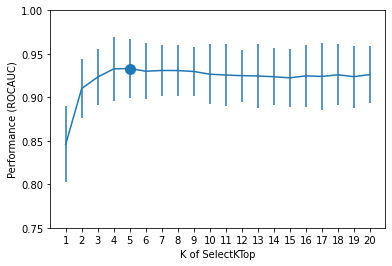

In [9]:
plt.errorbar(df_cv.param_selectktop__K, df_cv.mean_test_score, 1.96*df_cv.std_test_score)
plt.scatter(cv_best.param_selectktop__K, cv_best.mean_test_score, s=100)
plt.ylim(0.75, 1)
plt.xlabel('K of SelectKTop')
plt.xticks(df_cv.param_selectktop__K.astype(int))
plt.ylabel('Performance (ROCAUC)')
plt.show()

*No nosso experimento controlado, encontramos algumas poucas variáveis a mais do que o correto (e ficamos com todas as úteis).*

In [10]:
grid.best_estimator_.steps[0][1].get_feature_names_out()

array(['column_1', 'column_2', 'column_3', 'column_4', 'column_10'],
      dtype=object)

*Vale citar que podemos deixar esse método mais robusto variando o `random_state` do `base_estimator` e tendo uma distribuição de importâncias para cada variável ao invés de apenas um valor único (que naturalmente é mais ruidoso). Utilizar essa técnica com o SHAP para medir a importância (passando por exemplo o [`SHAPImportanceRandomForestClassifier`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py) como `base_estimator` do [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py)) é algo muito utilizado por alguns cientistas do [DataLab](https://br.linkedin.com/showcase/serasa-experian-datalab) como alternativa ao Boruta que, como vamos ver, costuma ser muito demorado.*

### Selecionando as `K` melhores variáveis com ponto de corte sugerido por uma variável aleatória

Criar uma variável de ruído, ou seja, que sabidamente não é útil para a previsão, nos auxilia a ter um ponto de corte para filtro das variáveis que demonstram ajudar na previsão. A ideia dessa abordagem é medir a importância da variável aleatória e ficar apenas com variáveis que se demonstrarem mais importantes do que ela.

Adicionando a nova coluna, por exemplo, amostrada de uma variável aleatória $\mathcal{N}(0,1)$ de forma independente, temos uma nova lista de importância das variáveis.

In [11]:
normal_noise_X = (X.assign(noise_column = np.random.RandomState(42).normal(size=X.shape[0])))
normal_noise_X[normal_noise_X.columns[::-1]].head()

,noise_column,column_20,column_19,...,column_3,column_2,column_1
0,0.496714,-0.491636,0.209659,...,0.912474,-1.323568,-1.050478
1,-0.138264,1.121031,-0.822420,...,1.777419,-2.747104,-1.580834
2,0.647689,-0.137372,0.850898,...,0.501004,-0.614600,-0.885704
3,1.523030,1.203884,0.615771,...,1.884777,-2.967793,-1.525438
4,-0.234153,-1.138833,0.622207,...,0.752233,-1.014619,-1.076826


In [12]:
normal_noise_rfc = RandomForestClassifier(random_state=42).fit(normal_noise_X, y)

df_imp_normal_noise = \
(pd.DataFrame(list(zip(normal_noise_X.columns, normal_noise_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
)

df_imp_normal_noise

,feature_name,feature_importance
1,column_2,0.266446
2,column_3,0.205667
3,column_4,0.087548
0,column_1,0.084593
...,...,...
8,column_9,0.019112
4,column_5,0.018706
18,column_19,0.018264
19,column_20,0.017692


Como a última variável é a nossa coluna sabidamente ruidosa, a ideia dessa técnica é selecionar apenas as variáveis que têm importância maior do que o limiar definido pela importância da variável não relacionada.

In [13]:
normal_noise_importance = \
normal_noise_rfc.feature_importances_[-1]

np.array(
 df_imp_normal_noise
 .query(f"feature_importance > {normal_noise_importance}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_6',
       'column_10', 'column_14'], dtype=object)

Vale observar que, a escolha da variável ruidosa como $\mathcal{N}(0,1)$ foi totalmente arbitrária. Entretanto, isso faz diferença e pode fazer com que a seleção de variáveis seja distinta. No nosso exemplo controlado, mudar o ruído para $\textrm{Exp}(1)$ nos faria selecionar variáveis finais diferentes totalmente por sorte.

In [14]:
exp_noise_X = \
(X.assign(noise_column = np.random.RandomState(42).exponential(size=X.shape[0])))
exp_noise_rfc = \
RandomForestClassifier(random_state=0).fit(exp_noise_X, y)
exp_noise_importance = \
exp_noise_rfc.feature_importances_[-1]

np.array(
 pd.DataFrame(list(zip(exp_noise_X.columns, exp_noise_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .query(f"feature_importance > {exp_noise_importance}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_14',
       'column_6', 'column_10', 'column_9', 'column_12', 'column_13',
       'column_7', 'column_18'], dtype=object)

Isso nos demonstra um problema desse método. Apesar de poderoso, por nos dar um jeito interessante de selecionar as variáveis sem escolher `K` de forma arbitrária, a escolha da distribuição da variável ruidosa é uma fonte de variação relevante.

Em muitos casos, ter variáveis discretas versus contínuas pode influenciar na medida de importância (como é o caso de árvores que, por terem mais quebras disponíveis, terão mais chance de escolher uma variável ruidosa contínua) ou, ainda, a própria escala da feature adicionada pode atrapalhar nessa mensuração (por exemplo, se estamos usando os coeficientes angulares de um [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).

Toda essa variabilidade pode fazer com que, as vezes, uma feature ruim seja selecionada, ao passo que uma variável boa seja descartada por azar.

O Boruta vem para tentar lidar com essas duas questões ao mesmo tempo: tentar manter a distribuição marginal das features ruidosas iguais às distribuições marginais das features originais, enquanto tenta ser robusto à variabilidade, repetindo o experimento algumas vezes.

## Ideias gerais do Boruta

Já existem muitos textos úteis que explicam o Boruta de forma didática e com exemplos. Como a ideia desse post não é ser redundante com a literatura e sim compilar ideias centrais de uso prático, vamos apenas citar os principais aspectos e deixar o convite para uma leitura detalhada de outras referências do tema como o post [Boruta Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a). A construção que fizemos anteriormente vai deixar as ideias do Boruta ainda mais claras, justificando o seu modo de ser.

Em resumo, o Boruta [[2,4](#bibliography)]:
- Cria variáveis não correlacionadas com a *target* ao embaralhar, entre as linhas, variáveis já presentes no dataset (essas são as variáveis que chamamos de *shadow*).
- Lida com a variabilidade repetindo o processo várias vezes e marcando quantas vezes a nossa variável de interesse ficou atrás do percentil `perc` dos `.feature_importances` das *shadow features* (por default `perc=100`, portanto, comparamos com o máximo dos `.feature_importances` das *shadow features*, isto é, se alguma *shadow* for melhor, já descartamos aquela variável de interesse naquela rodada).
- Por fim, um teste de hipótese é feito para avaliar se podemos afirmar com alguma significância estatística `alpha` que a feature de interesse é melhor que o percentil `perc` da importância das *shadow features*.
- O teste de hipótese divide o conjunto de features em três categorias:
    - As variáveis que estatisticamente são variáveis melhores que as *shadow features* (são as chamadas de `.support_`);
    - As variáveis que estatisticamente são equivalentes às variáveis *shadow* (variáveis que excluímos);
    - As variáveis que não são possíveis de afirmar com significância estatística como sendo melhores que as variáveis *shadow* (`.weak_support_`).
- Na prática, a partir do momento que ele tem confiança de que uma determinada variável não é importante, ele já a exclui das próximas iterações.

## O [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py)

Primeiro, precisamos instanciar um `base_estimator` que será utilizado dentro do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) para calcular a importância das variáveis (através do `.feature_importances_` ou do `.coef_`). É importante ressaltar que podemos adicionar hiper-parâmetros que acharmos relevantes para o problema, como o `class_weight` se temos um problema muito desbalanceado.

Quando usamos um cômite de árvores, é importante ter em mente que árvores profundas vão mudar o `.feature_importances_`, mas vão demorar mais para treinar. É justificável utilizar árvores mais rasas, uma vez que os ganhos mais expressivos são feitos nas primeiras quebras, usualmente.

O [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) aceita qualquer estimador que tenha o atributo `.feature_importances_` disponível após rodar o método `.fit(X, y)` [[5](#bibliography)]. Você pode utilizar isso a seu favor usando os estimadores mais adequados para o seu problema, inclusive, utilizando algoritmos baseados em árvores mais eficientes como as [`sklearn.ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) (tenha em mente que as Extra Randomized Trees vão ter seu `.feature_importances_` afetado pelo método de construção e isso pode impactar a escolha final de variáveis).

Para exemplificar a utilização prática da biblioteca, vou utilizar o [`SHAPImportanceRandomForestClassifier`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py) que criamos anteriormente (basicamente um [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) com SHAP no lugar do `.feature_importances_` usual).

In [15]:
from boruta import BorutaPy

boruta_forest = SHAPImportanceRandomForestClassifier(max_depth=7, random_state=42)

Um ponto de atenção que não é necessariamente claro na documentação, é que o parâmetro `n_estimators` do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) sobrescreve o `n_estimators` do estimador como podemos ver no [código fonte do BorutaPy](https://github.com/scikit-learn-contrib/boruta_py/blob/3cf4de864e83ad0c50e0cfa177b2bc2aa4735256/boruta/boruta_py.py#L268):
```python
# set n_estimators
if self.n_estimators != 'auto':
    self.estimator.set_params(n_estimators=self.n_estimators)
```
Por default, temos `n_estimators=1000`. Se `n_estimators='auto'`, então [uma regra baseada no número de features que estamos avaliando é feita para escolher o número de árvores do ensemble](https://github.com/scikit-learn-contrib/boruta_py/blob/3cf4de864e83ad0c50e0cfa177b2bc2aa4735256/boruta/boruta_py.py#L371).

Por fim, `alpha` e `perc` são os outros parâmetros importantes do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) que você deveria ficar atento:
- O `perc` (percentil do `.feature_importances_` das *shadow features* utilizado para decidir se as variáveis foram boas ou não naquela determinada rodada) é um `int` que vai de 0 a 100. Quanto mais próximo de 100, mais rigoroso estamos sendo na hora de avaliar nossas features. Pela aleatoriedade, alguns `.feature_importances_` de *shadow features* podem ser grandes e muito rigorosos com o critério de corte, nesse caso, isso será ruim porque estaremos excluindo variáveis marginais que são relevantes, mas não têm uma importância tão expressiva. O default desse parâmetro é 100, mas recomendo abaixá-lo levemente (para 90, por exemplo) caso esteja trabalhando com um problema com muitas variáveis, desse modo haverá maior chance de se ter uma *shadow feature* com importância alta.
- O `alpha` é um float que vai de 0 a 1 e é importante para delimitar a partição que fazemos do conjunto de variáveis (`.support_weak_`, `.support` e excluídas), uma vez que determinará o rigor de certeza que queremos ter para afirmar que uma determinada feature é relevante ou não para o problema de classificação (ou regressão). O default desse parâmetro é 0.05, e eu não tenho o costume de alterá-lo, pois prefiro mantê-lo fixo e variar o `perc` já que os dois se relacionam.

In [16]:
%%time

boruta = \
(BorutaPy(
    estimator=boruta_forest,
    n_estimators=50,
    max_iter=100, # number of trials to perform
    random_state=42)
 .fit(np.array(X), np.array(y)) # fit accepts np.array, not pd.DataFrame
)

CPU times: total: 1min 21s
Wall time: 1min 27s


Por fim, é fácil resgatar as features com os atributos `.support_` e `.support_weak_`.

In [17]:
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

print('Support columns:', green_area)
print('Weak support columns:', blue_area)

Support columns: ['column_1', 'column_2', 'column_3', 'column_4', 'column_10']
Weak support columns: ['column_9']


## Trade-off de "qualidade da seleção" vs "tempo" quando damos um undersample

Quando temos um dataset muito grande, o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) pode demorar bastante tempo para rodar pelo processo de criar tantas variáveis *shadows* quanto temos no conjunto inicial de variáveis. Em muitas aplicações práticas é necessário aplicar o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) em um subconjunto do seu conjunto de treinamento.

Faremos aqui um experimento para ver, em um caso sintético de `make_classification` com `n_samples=5000`, `n_features=100`, `n_informative=40` e `n_redundant=10`, como seriam as escolhas de variáveis de um [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) conforme variamos o parâmetro `frac` de um [`.sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) feito na base de desenvolvimento.

In [18]:
from boruta_sample_experiment import experiment, plot_heatmap, plot_percentage_time

dic_sample, matrix, X_big, y_big = \
experiment(fracs=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

100%|██████████| 11/11 [14:08<00:00, 77.18s/it]


Como o número de variáveis informativas mais o número de variáveis redundantes é 50 então, nesse exemplo controlado, metade das nossas features são importantes. No plot abaixo, para diferentes valores de `frac` (fração dos exemplos da base usado para treinar o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py)) vemos quais variáveis estão sendo escolhidas. Idealmente, o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) deveria conseguir identificar que as primeiras 50 variáveis (eixo x) são as úteis e selecioná-las (pintando-as de verde), enquanto exclui as 50 demais (pintando-as de azul), haja vista que são ruído. Conforme variamos o `frac` (eixo y), vemos como ele se comporta.

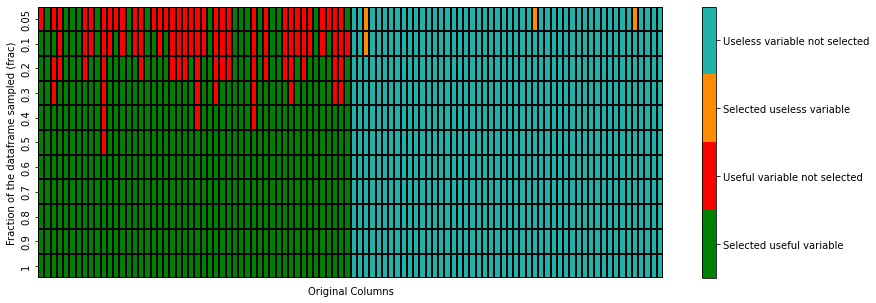

In [19]:
plot_heatmap(dic_sample, matrix)

Na primeira figura abaixo, vemos uma sumarização do plot anterior variando o `frac` (eixo x), enquanto observamos a porcentagem das variáveis úteis (em verde) e inúteis (em laranja) que são escolhidas. No gráfico ao lado, há uma análise de tempo (de treinamento do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py)) e performance do modelo treinado com as variáveis escolhidas naquele valor de `frac`.

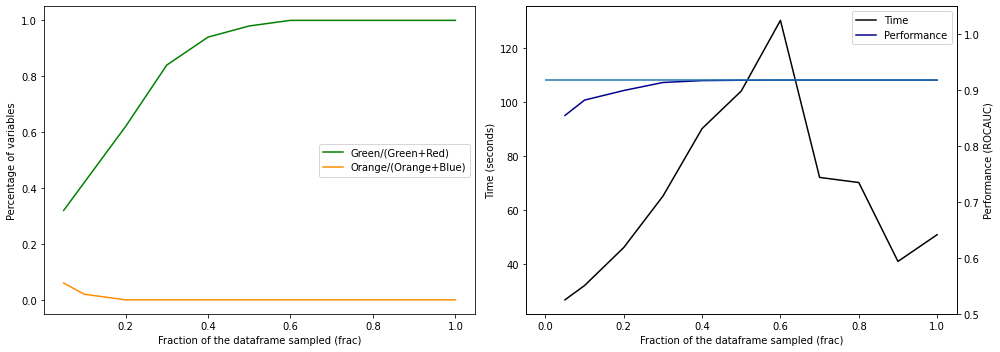

In [20]:
plot_percentage_time(dic_sample, matrix, X_big, y_big)

Como podemos ver, não precisamos de todas as amostras para treinar o nosso [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py). No exemplo anterior, apesar da nossa amostra ter 5000 elementos, com algo em torno de 3000 exemplos, já era possível encontrar perfeitamente todas as 50 variáveis úteis para o nosso problema.

Na minha experiência utilizando o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py), me sinto confortável com _uma amostra com 15 vezes mais exemplos do que features (ou seja, `n_samples>=15*n_features`)_. Nesse limiar, já costumo ter resultados bons em termos de seleção de variáveis e é possível rodar o algoritmo (em tempo satisfatório para desenvolvimento) com um `max_depth` controlado. Colocando um exemplo numérico: se, no [DataLab](https://br.linkedin.com/showcase/serasa-experian-datalab), estou trabalhando com um problema de 5 mil variáveis, me sinto confortável em rodar o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) em uma amostra de 75 mil linhas, mesmo tendo muito mais exemplos na base de desenvolvimento.

Por outro lado, o exemplo anterior nos mostra que nem sempre isso é o melhor, mesmo em questão de tempo. O [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py), na prática, não vai rodar por `max_iter` se já tiver certeza (no nível de significância `alpha`) das variáveis que ele acha úteis para o problema, que ele já exclui (ou seleciona) no meio do caminho. No experimento anterior, ter mais exemplos, na verdade, fez com que o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) ficasse com mais certeza de forma mais rápida sobre as variáveis. Na prática, isso dificilmente acontece.

## Usando o Boruta na prática e algumas alternativas

As ideias por trás do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) são muito interessantes, mas o algoritmo final é temporalmente custoso. Por sorte, podemos utilizar as ideias da construção para fazer variações espertas que podem ser alternativas se uma rodada inicial (com `max_depth ~ 10`, `perc=90` e `n_estimators=500`) estiver demorando demais:
1. Utilizar o [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) com alguma métrica de `.feature_importances_` mais robusta (como o SHAP, usando algo como nosso [`SHAPImportanceRandomForestClassifier`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py)) e tendo cuidado com a escolha do `K`;
2. Adaptar o [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) que construímos para um versão ainda mais robusta que lida com uma distribuição de `.feature_importances_` ao invés de apenas um estimador (aliás, esse é um ótimo exercício para o leitor interessado em entender melhor a [API do scikit-learn](https://scikit-learn.org/stable/developers/develop.html));
3. Adaptar o [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) para um "`SelectAboveNoise`", que explicamos anteriormente, criando as variáveis aleatórias a partir do [`numpy.random`](https://numpy.org/doc/stable/reference/random/index.html) (outro exercício muito bom);
4. Utilizar o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) com algoritmos mais rápidos (como [`sklearn.ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)), mas lembrando que seu treinamento (ainda mais randomizado) vai afetar o `.feature_importances_` e, consequentemente, o resultado final.
5. Reduzir a amostra utilizada para treino do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) respeitando a *rule of thumb* de `n_samples>=15*n_features`.
6. Mexer mais estruturalmente no algoritmo de forma que ele crie menos variáveis *shadows* em problemas com muitas variáveis (*to be tested*).

Se o seu problema é razoavelmente pequeno, usar o [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) com o SHAP e otimizar os hiper-parâmetros do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) é uma boa opção. Para isso, será útil utilizar o [`Boruta`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/boruta_selector.py) que criei no arquivo [`boruta_selector.py`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/boruta_selector.py) no [repositório deste post](https://github.com/vitaliset/blog-notebooks/tree/main/DataLab_Blog_Boruta_2022_09_05). Ele já está no formato adequado de [`Selector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectorMixin.html) do scikit-learn e pode ser utilizado da mesma forma que vimos o [`SelectKTop`](https://github.com/vitaliset/blog-notebooks/blob/main/DataLab_Blog_Boruta_2022_09_05/selectktop_selector.py) sendo usado (com o pipelines e qualquer [`BaseSearchCV`](https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/model_selection/_search.py#L372) do scikit-learn).

## Conclusão

Seleção de variáveis é um assunto necessário quando queremos garantir ter um modelo robusto. Neste post vimos uma das técnicas mais úteis para abordar esse problema enquanto, ao entender suas ideias, discutimos como adaptá-la para uma variedade de casos específicos. Mesmo que você não consiga usar o Boruta no seu problema em questão, as ideias aqui expostas permitem que você faça uma seleção de variáveis sabendo melhor as falhas e os benefícios de abordagens usuais do mercado.

## <a name="bibliography">Referências</a>

[1] [Foundations of Machine Learning. Mehryar Mohri, Afshin Rostamizadeh, and Ameet Talwalkar. MIT Press, Second Edition, 2018](https://cs.nyu.edu/~mohri/mlbook/).

[2] [Feature Selection with the Boruta Package. Miron B. Kursa, Witold R. Rudnicki. Journal of Statistical Software](https://www.jstatsoft.org/article/view/v036i11).

[3] [Decision and Classification Trees, Clearly Explained!!!. Josh Starmer. StatQuest with Josh Starmer](https://youtu.be/_L39rN6gz7Y).

[4] [Boruta Explained Exactly How You Wished Someone Explained to You. Samuele Mazzanti. Towards Data Science](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a).

[5] [boruta_py README.md documentation. Daniel Homola](https://github.com/scikit-learn-contrib/boruta_py).

Para mais dicas práticas de uso (e com um argumento de autoridade muito melhor que o meu), o autor do Boruta tem o guia [Boruta for those in a hurry](https://cran.r-project.org/web/packages/Boruta/vignettes/inahurry.pdf) que, apesar de estar escrito em R, tem dicas práticas interessantes de alguém que conhece a implementação com muita profundidade.

___